In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
from IPython.display import clear_output
from itertools import product, combinations
import json
from sklearn.preprocessing import StandardScaler

In [128]:
league_id = 71 # Choose the league id

season_file = '2008-2021'

first_season = 2012
last_season = 2021

features = ['PTS_A', 'PTS_CON_A', 'FG_PCT_A', 'FG3_PCT_A', 'FT_PCT_A', 'REB_A', 'TOV_A', 'SEASON_A_PCT', 'PER_A', 'ELO_A', 'MATCHUP_A_PCT', 'HA_A_PCT', 'STREAK_A', 'LAST_GAMES_PCT_A', 'HA_LAST_GAMES_PCT_A', 'OFF_RTG_A', 'DEF_RTG_A',
            'PTS_B', 'PTS_CON_B', 'FG_PCT_B', 'FG3_PCT_B', 'FT_PCT_B', 'REB_B', 'TOV_B', 'SEASON_B_PCT', 'PER_B', 'ELO_B', 'MATCHUP_B_PCT', 'HA_B_PCT', 'STREAK_B', 'LAST_GAMES_PCT_B', 'HA_LAST_GAMES_PCT_B', 'OFF_RTG_B', 'DEF_RTG_B']
targets = ['GAME_PTS_A', 'GAME_PTS_B']

min_threshold = 1.75
max_threshold = 10

first_attr_index = 7

# default_stake = 50
bankroll = 2000
stake = 0.025

In [129]:
print('\nGetting data for the model...')

season = "{}-{}".format(first_season, last_season)

default_path = f'./leagues/{league_id}'
whole_dataset = pd.read_csv('./data/{}.csv'.format(season_file))
whole_dataset = whole_dataset.loc[(whole_dataset['ODDS_A'].notna()) & (whole_dataset['ODDS_B'].notna())]
whole_dataset['GAME_DATE'] = pd.to_datetime(whole_dataset['GAME_DATE']).dt.date


Getting data for the model...


In [130]:
whole_dataset.tail()

,Unnamed: 0,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,TOTALS_LINE,SPREAD_LINE,PTS_A,...,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,WINNER,GAME_PTS_A,GAME_PTS_B
14464,14464,2021,2022-04-10,NYK,TOR,1.96,1.89,214.0,NaN,110.1,...,0.8,0.426210,-3,0.8,0.8,116.418296,116.418296,H,105,94
14465,14465,2021,2022-04-10,ORL,MIA,3.39,1.35,218.0,6.0,100.5,...,0.8,0.466592,-6,0.6,0.8,116.439241,116.439241,H,125,111
14466,14466,2021,2022-04-10,PHI,DET,1.37,3.23,221.0,6.5,119.6,...,0.2,0.389988,-2,0.4,0.6,108.780001,108.780001,H,118,106
14467,14467,2021,2022-04-10,PHX,SAC,1.19,5.14,227.0,9.0,116.4,...,0.4,0.334146,-3,0.4,0.6,107.126278,107.126278,A,109,116
14468,14468,2021,2022-04-10,POR,UTA,10.90,1.06,220.0,17.0,100.7,...,0.7,0.413349,-1,0.3,0.0,114.468630,114.468630,A,80,111


In [131]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    
    path = 'charts'
    if not os.path.exists(path):
        os.makedirs(path)
    
    plt.savefig(f"{path}/{title.replace(' ','_').lower()}.png", dpi=300)
    plt.show()

def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    try:
        data_converted = np.unique(data, return_counts=True)[1]
        plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
        plt.title(title)
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show() 
    except Exception as e:
        print(f'Error when trying to plot the pie chart: {e}')

def check_bet_worth(prediction, odds_home, odds_away):
    return ((prediction == 'H' and (odds_home > min_threshold and odds_home < max_threshold)) or 
            (prediction == 'A' and (odds_away > min_threshold and odds_away < max_threshold)))

def check_model_performance_on_game(game, prediction, bet_value):
    game_money = 0
    
    if check_bet_worth(prediction, game['ODDS_A'], game['ODDS_B']):
        if game['WINNER'] == prediction and game['WINNER'] == 'H':
            game_money = (bet_value*game['ODDS_A'] - bet_value)
        elif game['WINNER'] == prediction and game['WINNER'] == 'A':
            game_money = (bet_value*game['ODDS_B'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

def get_bet_value(bankroll):
    bankroll_baseline = round(bankroll / 1000, 0) * 1000
    return stake * bankroll_baseline
#     return default_stake

def get_pred_odds(probs):
    return 1/probs[0], 1/probs[1] # Away, Home

In [132]:
def get_feature_correlation_matrix(dataset):
    print('\nGetting the feature correlation matrix...')

    import seaborn as sns

    try:
        dependent_variables = dataset.iloc[:,first_attr_index:]
        corrmat = dependent_variables.corr()
        top_corr_features = corrmat.index
        plt.figure(figsize=(13,13))
        title = 'Feature Correlation'
        plt.title(title)
        #plot heat map
        sns.set(font_scale=0.6)
        g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show()
    except:
        print('No correlation matrix for the selected model.')

In [141]:
def simulate_by_model(predictions, dataset_itr):
    money_by_date = []
    bets = []
    money_by_team = dict()
    total_invested = 0
    parlays = []
    outcome_predictions = {'H': 0, 'A': 0}
    strikes = 0
    totals_bets = 0
    totals_hits = 0

    money_by_date.append({
        'date': dataset_itr.iloc[0,2],
        'date_profit': 0,
        'total_bankroll': bankroll
    })

    for index, game in dataset_itr.iterrows():
        # Next date
        if game['GAME_DATE'] != money_by_date[-1]['date']:    
            # Tracking built parlay
            for parlay in parlays:
#                 if parlay['parlay_odds'] >= 1.5:
                bet_value = get_bet_value(money_by_date[-1]['total_bankroll'])
                game_money_model = ((parlay['parlay_odds'] * bet_value) - bet_value) if parlay['parlay_won'] else -bet_value
                total_invested += bet_value
                money_by_date[-1]['date_profit'] += game_money_model
                money_by_date[-1]['total_bankroll'] += game_money_model

            parlays = []
            money_by_date.append({
                'date': game['GAME_DATE'],
                'date_profit': 0,
                'total_bankroll': money_by_date[-1]['total_bankroll']
            })

        if game['TEAM_A'] not in money_by_team:
            money_by_team[game['TEAM_A']] = 0
        if game['TEAM_B'] not in money_by_team:
            money_by_team[game['TEAM_B']] = 0

        pts_a_pred, pts_b_pred = predictions[index]
        prediction = 'H' if pts_a_pred > pts_b_pred else 'A'
        
        if game['TOTALS_LINE']:
            totals_bets += 1
            if (game['GAME_PTS_A'] + game['GAME_PTS_B'] > game['TOTALS_LINE'] and pts_a_pred + pts_b_pred > game['TOTALS_LINE']) or (game['GAME_PTS_A'] + game['GAME_PTS_B'] < game['TOTALS_LINE'] and pts_a_pred + pts_b_pred < game['TOTALS_LINE']):
                totals_hits += 1
        
        if prediction == game['WINNER']:
            strikes += 1

        game_money_model = 0
        bet_value = get_bet_value(money_by_date[-1]['total_bankroll'])

        game_money_model = check_model_performance_on_game(game, prediction, bet_value)

        if game_money_model != 0:       
            if game['WINNER'] == prediction and game['WINNER'] == 'H':
                bets.append(['HOME', game['ODDS_A'], 1])
                money_by_team[game['TEAM_A']] += game_money_model
            elif game['WINNER'] == prediction and game['WINNER'] == 'A':
                bets.append(['AWAY', game['ODDS_B'], 1])
                money_by_team[game['TEAM_B']] += game_money_model
            else:
                if prediction == 'H':
                    bets.append(['HOME', game['ODDS_A'], 0])
                    money_by_team[game['TEAM_A']] += game_money_model
                else:
                    bets.append(['AWAY', game['ODDS_B'], 0])
                    money_by_team[game['TEAM_B']] += game_money_model

            total_invested += bet_value
#         else:
#             if not len(parlays) or parlays[-1]['parlay_odds'] > 1.75 or len(parlays[-1]['parlay_matches']) > 2:
#                 parlays.append({
#                     'parlay_odds': 0,
#                     'parlay_won': True,
#                     'parlay_matches': []
#                 })
            
#             odds = game['ODDS_A'] if prediction == 'H' else game['ODDS_B']
#             parlays[-1]['parlay_odds'] = odds * parlays[-1]['parlay_odds'] if parlays[-1]['parlay_odds'] > 0 else odds # Parlay odds
#             parlays[-1]['parlay_matches'].append(f"{game['TEAM_A']} ({game['ODDS_A']}) x ({game['ODDS_B']}) {game['TEAM_B']}") # Parlay match counter
            
#         if game_money_model == 0 and prediction != game['WINNER']:
#             parlays[-1]['parlay_won'] = False 

        outcome_predictions[prediction] += 1

#         print(f"\nGAME DATE: {game['GAME_DATE']}")
#         print(f"GAME OUTCOME: {game['OUTCOME']}")
#         print(f"PREDICTED OUTCOME: {prediction}")
#         print(f"GAME: {game['HOME_TEAM']} ({game['HOME_ODDS']}) x ({game['AWAY_ODDS']}) {game['AWAY_TEAM']}")

        money_by_date[-1]['date_profit'] += game_money_model
        money_by_date[-1]['total_bankroll'] += game_money_model
        
    return {
        'results': money_by_date,
        'outcome_distribution': outcome_predictions,
        'bets': bets,
        'profit_by_team': money_by_team,
        'total_invested': total_invested,
        'strike_rate': strikes * 100 / len(dataset_itr.index),
        'totals_strike_rate': totals_hits * 100 / totals_bets,
    }


In [142]:
def save_league_season_results(results, season_train, season_test):
    path = f"results/regression"
    file_name = f"{season_train}-{season_test}.json"

    if not os.path.exists(path):
        os.makedirs(path)

    with open(f"{path}/{file_name}", 'w') as f:
        json.dump(results, f, indent = 4, sort_keys = True, default = str)

In [188]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 

def train_linear_regression_model(dataset):
    X = dataset.loc[:, features]
    y = dataset[targets]
    
    poly_reg = PolynomialFeatures(4)
    X_poly = poly_reg.fit_transform(X)
    
    model = LinearRegression()
    
    model.fit(X_poly, y)
    
    return model, poly_reg

In [189]:
def predict(dataset_train, dataset_itr):
    
    model, poly_reg = train_linear_regression_model(dataset_train)

    X = dataset_itr.loc[:, features]
    X_poly = poly_reg.transform(X)
    
    predictions = model.predict(X_poly)
    
    return predictions

In [190]:
def simulate(season):
    print(f"\Simultating the results for season {season}...")
    
    dataset_train = whole_dataset.loc[(whole_dataset['SEASON_ID'] >= first_season) & (whole_dataset['SEASON_ID'] < season)].reset_index(drop=True)
    dataset_itr = whole_dataset.loc[whole_dataset['SEASON_ID'] == season].reset_index(drop=True)
    
    clear_output(wait=True)

    print(f"Season {season}/{last_season}")

    predictions = predict(dataset_train, dataset_itr)

    result = simulate_by_model(predictions, dataset_itr)
    result['seasons'] = f"{first_season}-{season}"
        
    save_league_season_results([result], first_season, season)
        
    return result


In [191]:
results = []

for season in range(first_season + 1, last_season + 1):
    results.append(simulate(season))

Season 2021/2021


In [192]:
results.sort(key=lambda x: x['results'][-1]['total_bankroll'], reverse=True)

In [193]:
def print_bankroll_update(result):
    won = result['results'][-1]['total_bankroll'] - bankroll
    print(f"\nSeasons: {result['seasons']} // Accuracy: {round(result['strike_rate'], 2)}%")
    print(f"Yield: {round(won*100/result['total_invested'], 2)}% // Bet Accuracy: {round(len([r for r in result['bets'] if r[2]])*100/len(result['bets']), 2)}% \nBankroll: {round(result['results'][-1]['total_bankroll'], 2)} // Won: {round(won, 2)} // Margin: {round(100*won/bankroll, 2)}%")
    print(f"Totals Accuracy: {round(result['totals_strike_rate'], 2)}%")

In [194]:
for r in results:
    print_bankroll_update(r)


Seasons: 2012-2016 // Accuracy: 52.79%
Yield: 5.2% // Bet Accuracy: 39.86% 
Bankroll: 6670.0 // Won: 4670.0 // Margin: 233.5%
Totals Accuracy: 51.3%

Seasons: 2012-2015 // Accuracy: 53.49%
Yield: -3.01% // Bet Accuracy: 35.99% 
Bankroll: 1390.0 // Won: -610.0 // Margin: -30.5%
Totals Accuracy: 50.23%

Seasons: 2012-2021 // Accuracy: 50.93%
Yield: -4.14% // Bet Accuracy: 36.63% 
Bankroll: 1305.75 // Won: -694.25 // Margin: -34.71%
Totals Accuracy: 47.01%

Seasons: 2012-2018 // Accuracy: 52.61%
Yield: -2.14% // Bet Accuracy: 37.13% 
Bankroll: 1279.0 // Won: -721.0 // Margin: -36.05%
Totals Accuracy: 51.21%

Seasons: 2012-2020 // Accuracy: 52.53%
Yield: -6.84% // Bet Accuracy: 38.12% 
Bankroll: 907.5 // Won: -1092.5 // Margin: -54.62%
Totals Accuracy: 48.79%

Seasons: 2012-2014 // Accuracy: 53.26%
Yield: -5.91% // Bet Accuracy: 35.96% 
Bankroll: 815.25 // Won: -1184.75 // Margin: -59.24%
Totals Accuracy: 49.81%

Seasons: 2012-2017 // Accuracy: 50.7%
Yield: -8.96% // Bet Accuracy: 35.26% 

In [195]:
# result_for_analysis = results[0]
result_for_analysis = results[0]

In [196]:
print(result_for_analysis['outcome_distribution'])

{'H': 558, 'A': 516}


In [197]:
print('\nPlotting charts...')

models_tracking =  [np.array([x['total_bankroll'] for x in result_for_analysis['results']], dtype=np.float32)]

money_by_date = np.array([[r['date'], r['total_bankroll']] for r in result_for_analysis['results']], dtype=str)
correct_bets = list(filter(lambda x: x[2] == 1, result_for_analysis['bets']))
missed_bets = list(filter(lambda x: x[2] == 0, result_for_analysis['bets']))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(result_for_analysis['profit_by_team'].items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


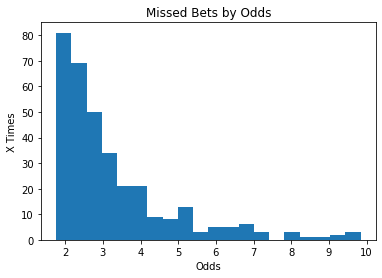

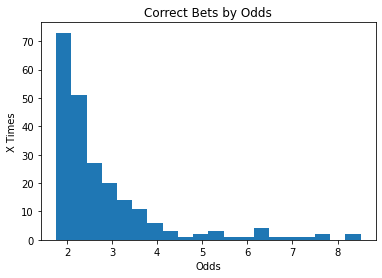

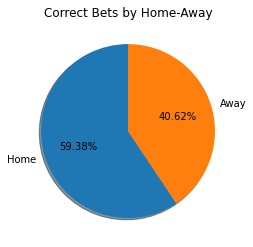

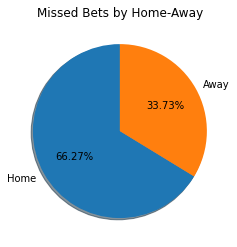

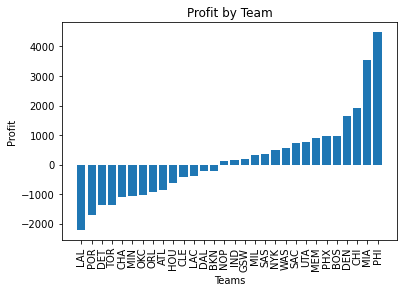

In [198]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

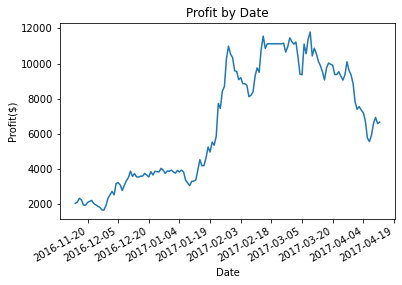

In [199]:
xpoints = money_by_date[:, 0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)

title = "Profit by Date"
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()